<a href="https://colab.research.google.com/github/GHes31415/OT/blob/main/bezier_gauss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline 
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.animation import FuncAnimation


In [2]:
normal = lambda x,mu,sigma : np.exp(-(x-mu)**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)

Algorithm for computing bezier interpolation 

In [3]:
def deCastelajau(t,coefs):

  beta = [c for c in coefs]

  n = len(beta)

  
  for j in range(1,n):

    for i in range(n-j):

      beta[i] = (1-t)*beta[i]+beta[i+1]*t

  return beta[0]

In [4]:
def Bezier_interpolation(coefs,N):

  time = np.linspace(0,1,N)
  interp = np.array([deCastelajau(t,coefs) for t in time])

  return interp


Test in 2D. This test matches the interpolation for 1D Gaussians. This is the path in the mean-variance space

In [5]:
coefs = np.array([[0,1],[-8,1/8],[8,1/8],[0,1]])

In [6]:
interp = Bezier_interpolation(coefs,50)
x = interp[:,0]
y = interp[:,1]

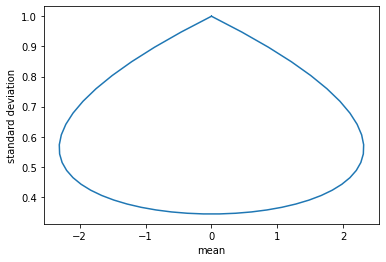

In [7]:
plt.plot(x,y)
plt.xlabel('mean')
plt.ylabel('standard deviation')
plt.show()

Test for 1D Gaussians

In [8]:
partition = 150

x = np.linspace(-4,4,partition)


In [9]:
vect_means = np.array([0,-8,8,0])
vect_var = np.array([1,1/8,1/8,1])

In [10]:
N = 50
interp_means = Bezier_interpolation(vect_means,N)

interp_var = Bezier_interpolation(vect_var,N)

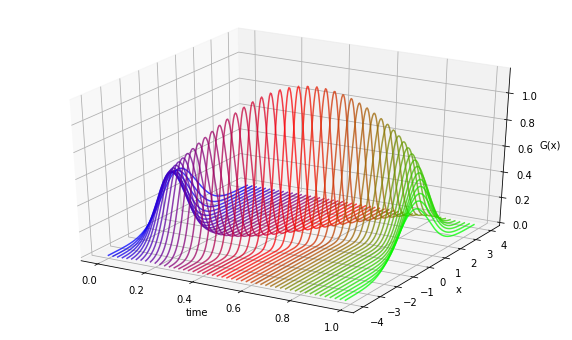

In [11]:
#%matplotlib widget
fig = plt.figure(figsize = (10,6))

ax = plt.axes(projection='3d')

cmap = plt.get_cmap('brg')
 
colors =[ cmap(i) for i in np.linspace(0,1,N)]

for i ,color in enumerate(colors,start = 0):
  t = i/N*np.ones(partition)
  y = normal(x,interp_means[i],interp_var[i])
  ax.plot3D(t,x,y, alpha = 0.75, color = color)
  #plt.legend()
  ax.set_xlabel('time')
  ax.set_ylabel('x')
  ax.set_zlabel('G(x)')

plt.show()

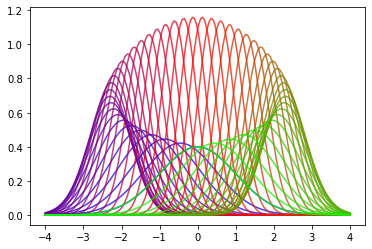

In [12]:
cmap = plt.get_cmap('brg')
 
colors =[ cmap(i) for i in np.linspace(0,1,N)]
for i ,color in enumerate(colors,start = 0):

  y = normal(x,interp_means[i],interp_var[i])

  plt.plot(x,y, alpha = 0.75, color = color)

plt.show()



Experiment 2D

In [58]:
# Code for multivariate gaussian 

def multi_gauss(x,mu,sigma):

  x_mu = x-mu

  sig_inv = np.linalg.inv(sigma)

  arg_exp = (x_mu).T@sig_inv@(x_mu)

  det = np.linalg.det(2*np.pi*sigma)**(-1/2)

  return det*np.exp(-arg_exp/2)



In [100]:
vect_means_2D = np.array([[0,0],[2,-4],[6,-5]])

vect_var_2D = np.array([[[1,0],[0,1]],[[2,1],[0.5,1]],[[1,0],[0,1/2]]])

In [101]:
N = 10
interp_means = Bezier_interpolation(vect_means_2D,N)

interp_var = Bezier_interpolation(vect_var_2D,N)

In [102]:
partition = 100
x = y = np.linspace(-8,8,partition)

X,Y = np.meshgrid(x,y)


In [103]:
def eval_multi_gauss(X,Y,partition,mean,covariance):

  positions = np.dstack((X,Y))

  res = np.zeros_like(X)

  for i in range(partition):

    res[i,:] = np.array([multi_gauss(pos,mean,covariance) for pos in positions[i]])

  return res

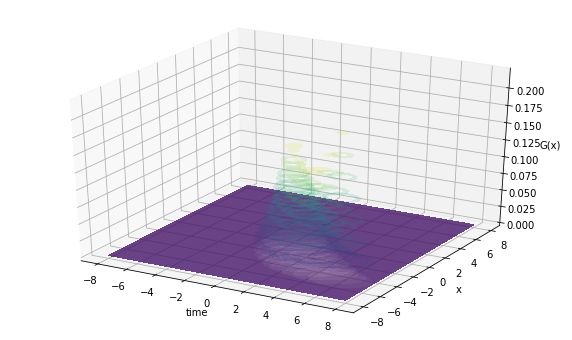

In [105]:
#%matplotlib widget
fig = plt.figure(figsize = (10,6))

ax = plt.axes(projection='3d')

cmap = plt.get_cmap('brg')
 
colors =[ cmap(i) for i in np.linspace(0,1,N)]

for i ,color in enumerate(colors,start = 0):
  t = i/N*np.ones(partition)
  res = eval_multi_gauss(X,Y,partition,interp_means[i],interp_var[i])
  ax.contourf(X,Y,res, alpha = 0.15)
  #plt.legend()
  ax.set_xlabel('time')
  ax.set_ylabel('x')
  ax.set_zlabel('G(x)')

plt.show()